## Imports and Some Settings

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy
import pandas as pd
import math
import time
import pickle
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True))
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 980, pci bus id: 0000:26:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## The Original Datasets: Load, Normalize

In [3]:
# load from files
raw_original_test_labels = idx2numpy.convert_from_file('datasets/fashion_mnist_test_labels.idx')
raw_original_test_data = idx2numpy.convert_from_file('datasets/fashion_mnist_test_data.idx')
raw_original_train_labels = idx2numpy.convert_from_file('datasets/fashion_mnist_train_labels.idx')
raw_original_train_data = idx2numpy.convert_from_file('datasets/fashion_mnist_train_data.idx')

# normalization
y_test = np.asarray(raw_original_test_labels, dtype=np.int32)
X_test = np.asarray(raw_original_test_data / 255.0, dtype=np.float32).reshape(-1, 28, 28, 1)
y_train = np.asarray(raw_original_train_labels, dtype=np.int32)
X_train = np.asarray(raw_original_train_data / 255.0, dtype=np.float32).reshape(-1, 28, 28, 1)
y_val = y_train[45000:]
X_val = X_train[45000:]
y_train = y_train[:45000]
X_train = X_train[:45000]

# just in case
IMG_SHAPE = (28,28,1)

## The Original Datasets: Display Some Images

In [4]:
def display_first_16_images(data):
    '''
    Displays first 16 images froma given data
    at the 4x4 figure
    :param data: given data
    '''
    fig = plt.figure(figsize=(13, 13))
    axes=[]
    plt.gray()
    for ii in range(16):
        axes.append(fig.add_subplot(4, 4, ii + 1) )
        plt.imshow(data[ii].reshape((28,28)))
    plt.tight_layout()

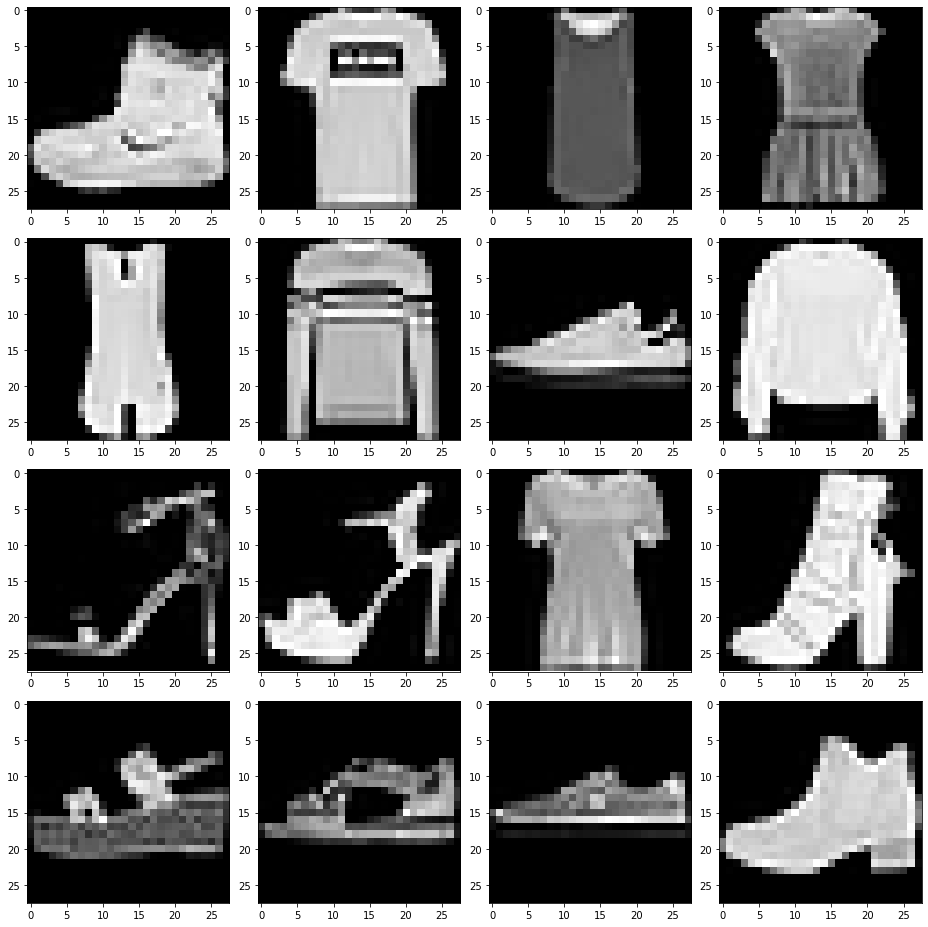

In [5]:
display_first_16_images(X_train)

## Augmentation Generators: Lukas's And Another Generators

In [6]:
lukas_augmentation = ImageDataGenerator(
    rotation_range=5, 
    horizontal_flip=True, 
    vertical_flip=True, 
    zoom_range=0.1)

In [7]:
another_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.5,
    zoom_range=(0.9, 1.1),
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='constant',
    cval=0)

In [8]:
def fit_aug_gen(data, aug_gen):
    '''
    Fits data to augmentation generator
    :param data: given data
    :param aug_gem: given generator
    '''
    aug_gen.fit(data)
    return aug_gen

## Lukas's Augmentation Generator: Display Some of Images

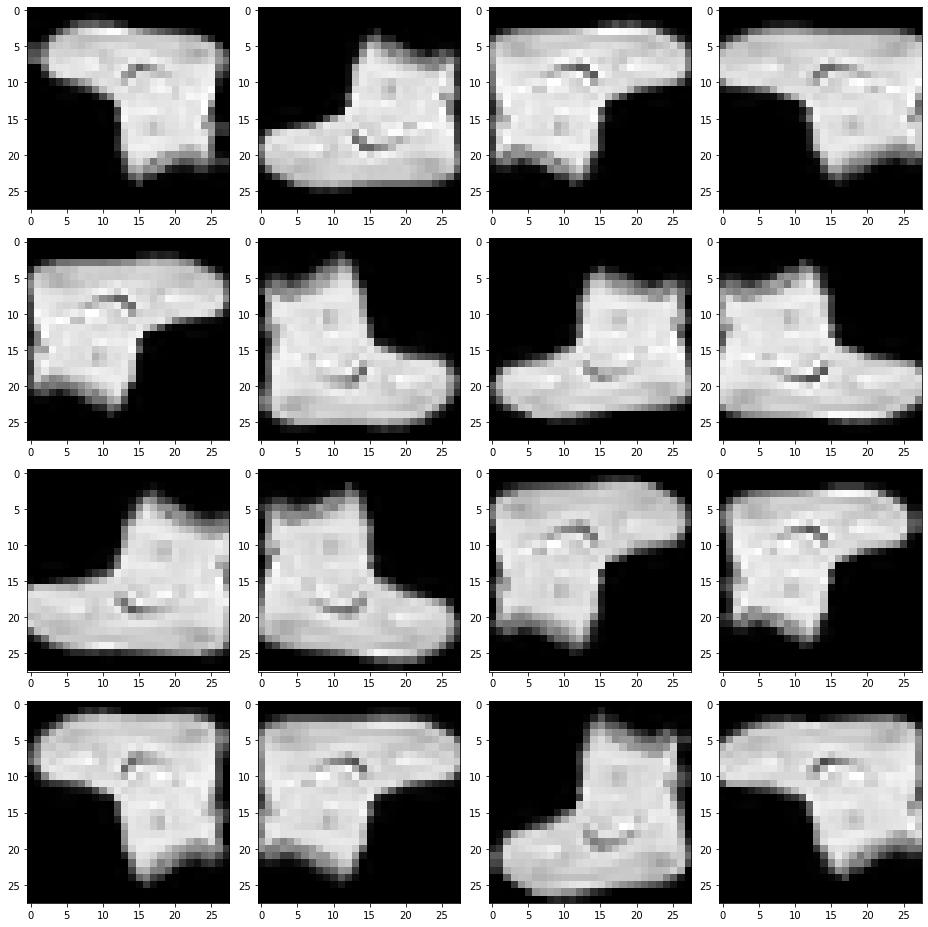

In [9]:
augmented_imgs = []
ii = 0
for batch in lukas_augmentation.flow(X_train[0].reshape((1,28,28,1))):
    augmented_imgs.append(batch[0].reshape((28,28)))
    ii += 1
    if ii > 16:
        break
display_first_16_images(augmented_imgs)

## Create Lukas's Models

In [10]:
lukas_model_1 = keras.Sequential([
    Conv2D(32, (3, 3), input_shape=IMG_SHAPE, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), input_shape=IMG_SHAPE, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

lukas_model_1.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

In [11]:
lukas_model_2 = keras.Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=IMG_SHAPE),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

lukas_model_2.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

In [12]:
lukas_model_3 = keras.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    Conv2D(256, 3, activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

lukas_model_3.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

## Simple Model

In [13]:
simple_model = keras.Sequential([
    keras.layers.Flatten(input_shape=IMG_SHAPE),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

simple_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

## Stolen Model:

In [14]:
mediums_model = keras.Sequential([
    Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=IMG_SHAPE),
    MaxPooling2D(pool_size=2),
    Dropout(0.3),
    Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

mediums_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

## All Models: Training, Evaluating, Predicting

In [15]:
def train_and_test_model(model, epochs, batch_size, name, aug_gen=None, verbose=0):
    '''
    Trains model - fits it to train dataset,
    at the same time it evaluate it using val datasets,
    it also test the final model on test dataset.
    By using tensorboard I can see it 'live' and then
    visualize the plots - history of evaluation
    :param model: nn model to use
    :param epochs: number of epochs
    :param batch_size: batch size :|
    :param name: model's name used while saving history
    :param aug_gen: augmented data generator, when there is none,
     then original dataset is used
    :param verbose: 0 - silent output, 1 - progress bar
    :return: fit history, test data evaluated loss and accuracy
    '''
    tensorboard = TensorBoard(log_dir="logs_fashion/{}".format(name))
    if aug_gen:
        history = model.fit(
            fit_aug_gen(X_train, aug_gen).flow(X_train, y_train, batch_size=batch_size),
            validation_data=(fit_aug_gen(X_val, aug_gen).flow(X_val, y_val, batch_size=batch_size)),
            steps_per_epoch=math.ceil(len(X_train) / batch_size), 
            epochs=epochs,
            validation_steps=math.ceil(len(X_val) / batch_size), 
            callbacks=[tensorboard],
            verbose=verbose)
    else:
        history = model.fit(
            X_train, 
            y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size, 
            callbacks=[tensorboard],
            verbose=verbose)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=verbose)
    return history, test_loss, test_acc

def count_time(f, p_1, p_2,p_3, p_4, p_5=None):
    """
    This function counts how long does the given
    function work, and also it returns the results
    :param f: given function
    :param p_1 - p_5: parameters for the given function
    :return: results of given function
    """
    start = time.perf_counter()
    res = f(p_1, p_2,p_3, p_4, p_5)
    total = time.perf_counter() - start
    print(f"Time for: {p_4} => {total}s")
    return res

In [16]:
LUKAS_1 = "Lukas_1"
LUKAS_2 = "Lukas_2"
LUKAS_3 = "Lukas_3"
SIMPLE = "Simple"
MEDIUMS = "Mediums"
TICK_LABELS = [LUKAS_1, LUKAS_2, LUKAS_3, SIMPLE, MEDIUMS]
AUG_1 = "_1"
AUG_2 = "_2"
AUG_3 = "_3"
LUKAS_AUGMENTATION = "Lukas Augmentation"
ANOTHER_AUGMENTATION = "Another Augmentation"
ORIGINAL_DATASET = "Original Dataset"
COLORS = ["r", "g", "b", "m", "y"]
EPOCHS = 30

In [17]:
_, loss_lukas_1_1, acc_lukas_1_1 = count_time(train_and_test_model, lukas_model_1, EPOCHS, 64, LUKAS_1+AUG_1, lukas_augmentation)
_, loss_lukas_2_1, acc_lukas_2_1 = count_time(train_and_test_model, lukas_model_2, EPOCHS, 64, LUKAS_2+AUG_1, lukas_augmentation)
_, loss_lukas_3_1, acc_lukas_3_1 = count_time(train_and_test_model, lukas_model_3, EPOCHS, 32, LUKAS_3+AUG_1, lukas_augmentation)
_, loss_simple_1,  acc_simple_1  = count_time(train_and_test_model, simple_model, EPOCHS, 64, SIMPLE+AUG_1, lukas_augmentation)
_, loss_mediums_1, acc_mediums_1 = count_time(train_and_test_model, mediums_model, EPOCHS, 64, MEDIUMS+AUG_1, lukas_augmentation)

Time for: Lukas_1_1 => 222.805835s
Time for: Lukas_2_1 => 221.057908s
Time for: Lukas_3_1 => 320.9693806s
Time for: Simple_1 => 220.67712470000004s
Time for: Mediums_1 => 222.05654700000002s


In [18]:
_, loss_lukas_1_2, acc_lukas_1_2 = count_time(train_and_test_model, lukas_model_1, EPOCHS, 64, LUKAS_1+AUG_2, another_augmentation)
_, loss_lukas_2_2, acc_lukas_2_2 = count_time(train_and_test_model, lukas_model_2, EPOCHS, 64, LUKAS_2+AUG_2, another_augmentation)
_, loss_lukas_3_2, acc_lukas_3_2 = count_time(train_and_test_model, lukas_model_3, EPOCHS, 32, LUKAS_3+AUG_2, another_augmentation)
_, loss_simple_2,  acc_simple_2  = count_time(train_and_test_model, simple_model, EPOCHS, 64, SIMPLE+AUG_2, another_augmentation)
_, loss_mediums_2, acc_mediums_2 = count_time(train_and_test_model, mediums_model, EPOCHS, 64, MEDIUMS+AUG_2, another_augmentation)

Time for: Lukas_1_2 => 278.65179319999993s
Time for: Lukas_2_2 => 276.2732570999999s
Time for: Lukas_3_2 => 334.54081610000026s
Time for: Simple_2 => 276.14402770000015s
Time for: Mediums_2 => 277.6652240999997s


In [19]:
_, loss_lukas_1_3, acc_lukas_1_3 = count_time(train_and_test_model, lukas_model_1, EPOCHS, 64, LUKAS_1+AUG_3)
_, loss_lukas_2_3, acc_lukas_2_3 = count_time(train_and_test_model, lukas_model_2, EPOCHS, 64, LUKAS_2+AUG_3)
_, loss_lukas_3_3, acc_lukas_3_3 = count_time(train_and_test_model, lukas_model_3, EPOCHS, 32, LUKAS_3+AUG_3)
_, loss_simple_3,  acc_simple_3  = count_time(train_and_test_model, simple_model, EPOCHS, 64, SIMPLE+AUG_3)
_, loss_mediums_3, acc_mediums_3 = count_time(train_and_test_model, mediums_model, EPOCHS, 64, MEDIUMS+AUG_3)

Time for: Lukas_1_3 => 83.18315340000026s
Time for: Lukas_2_3 => 61.8462685999998s
Time for: Lukas_3_3 => 295.7097407000001s
Time for: Simple_3 => 38.659846200000175s
Time for: Mediums_3 => 78.58892779999996s


## Some Methods To Display:Loss, Accuracy And Predictions

In [23]:
def set_sub_plot(sub, xlabel, ylabel, title):
    """
    Sets subplot's settings
    :param sub: given subplot
    :param xlabel: x axis label
    :param ylabel: y axis label
    :param title: plots title
    """
    sub.set_xlabel(xlabel, fontsize=10)
    sub.set_ylabel(ylabel, fontsize=10)
    sub.set_title(title)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    x_min = 0    
    x_max = 30
    y_min = 0
    y_max = 1.2
    if ylabel == 'Accuracy':
        y_min = 0.5
        y_max = 1
    sub.set_xlim(x_min, x_max)
    sub.set_ylim(y_min, y_max)

def display_plots(sub_a, sub_l, name, set_type, linestyle):
    """
    Displays 5 + 5 plots from saved files
    :param sub_a: subplot for accuracy
    :param sub_l: subplot for loss
    :param name: model's name
    :param set_type: 'validation' or 'train'
    :apram linestyle: plots linestyle
    """
    loss, acc = read_plots_from_file(name, set_type)
    xl = loss.values[:,1]
    yl = loss.values[:,2]
    xa = acc.values[:,1]
    ya = acc.values[:,2]
    sub_a.plot(xa, ya, linestyle, label=name[:-2])
    sub_l.plot(xl, yl, linestyle, label=name[:-2])
    sub_a.grid()
    sub_l.grid()
    sub_a.legend()
    sub_l.legend()

def read_plots_from_file(name, set_type):
    """
    Reads history of evaluation/fitting from saved files
    :param name: model's name
    :param set_type: 'validation' or 'train'
    """
    loss = pd.read_csv("logs_fashion/run-" + name + "_" + set_type + "-tag-epoch_loss.csv")
    acc = pd.read_csv("logs_fashion/run-" + name + "_" + set_type + "-tag-epoch_accuracy.csv")  
    return loss, acc


def show_models(i, fig, aug, aug_name, colors):
    """
    Calls displaying 5 + 5 plots, 3 times, 
    each for different type of datasets
    :param i: position for subplots on figure
    :param fig: figure on which plots will be displayed
    :param aug: aug - number of dataset's type
    :param aug_name: dataset's type name
    :apram colors: list of colors for plots
    """
    which_results = "validation"
    sub_a = fig.add_subplot(3, 2, i)
    sub_l = fig.add_subplot(3, 2, i+1)
    set_sub_plot(sub_a, "Epochs", 'Accuracy', aug_name+ " - Loss Values")
    set_sub_plot(sub_l, "Epochs", "Loss", aug_name+ " - Accuracy Values")
    display_plots(sub_a, sub_l, LUKAS_1+aug, which_results, "-"+ colors[0])
    display_plots(sub_a, sub_l, LUKAS_2+aug, which_results, "-"+ colors[1])
    display_plots(sub_a, sub_l, LUKAS_3+aug, which_results, "-"+ colors[2])
    display_plots(sub_a, sub_l, SIMPLE+aug, which_results, "-" + colors[3])
    display_plots(sub_a, sub_l, MEDIUMS+aug, which_results, "-" + colors[4])
    

def show_bar(i, name, ys, colors):
    """
    Displays bar graph for loss and accuracy values
    evaluated from test datasets
    :param i: position for subplots (subbar?) on figure
    :param name: dataset's (!) type name
    :apram colors: list of colors for bars
    """
    sub = fig.add_subplot(3, 2, i)
    sub.set_ylim(0,1.01)
    if i%2==1: sub.set_title(name + " - Test Accuracy Values")
    else: sub.set_title(name + " - Test Loss Values")
    ys = [round(buf * 1000) / 1000 for buf in ys]
    NEW_TICK_LABELS = [TICK_LABELS[ii] + ": " + str(ys[ii]) for ii in range(len(ys))]
    sub.bar(np.arange(1,len(ys)+1), ys, tick_label=NEW_TICK_LABELS, color=colors)

# Model Comparison:
    1. Lukas's Model 1    | Lukas's Augmentation | batch size = 64 | epochs = 100
    2. Lukas's Model 2    | Lukas's Augmentation | batch size = 64 | epochs = 100
    3. Lukas's Model 3    | Lukas's Augmentation | batch size = 32 | epochs = 100
    4. Simple Model       | Lukas's Augmentation | batch size = 64 | epochs = 100
    5. Medium's Model     | Lukas's Augmentation | batch size = 64 | epochs = 100
    
    6. Lukas's Model 1    | Another Augmentation | batch size = 64 | epochs = 100
    7. Lukas's Model 2    | Another Augmentation | batch size = 64 | epochs = 100
    8. Lukas's Model 3    | Another Augmentation | batch size = 32 | epochs = 100
    9. Simple Model       | Another Augmentation | batch size = 64 | epochs = 100
    10. Medium's Model    | Another Augmentation | batch size = 64 | epochs = 100
    
    11. Lukas's Model 1   | Original Data        | batch size = 64 | epochs = 100
    12. Lukas's Model 2   | Original Data        | batch size = 64 | epochs = 100
    13. Lukas's Model 3   | Original Data        | batch size = 32 | epochs = 100
    14. Simple Model      | Original Data        | batch size = 64 | epochs = 100
    15. Medium's Model    | Original Data        | batch size = 64 | epochs = 100

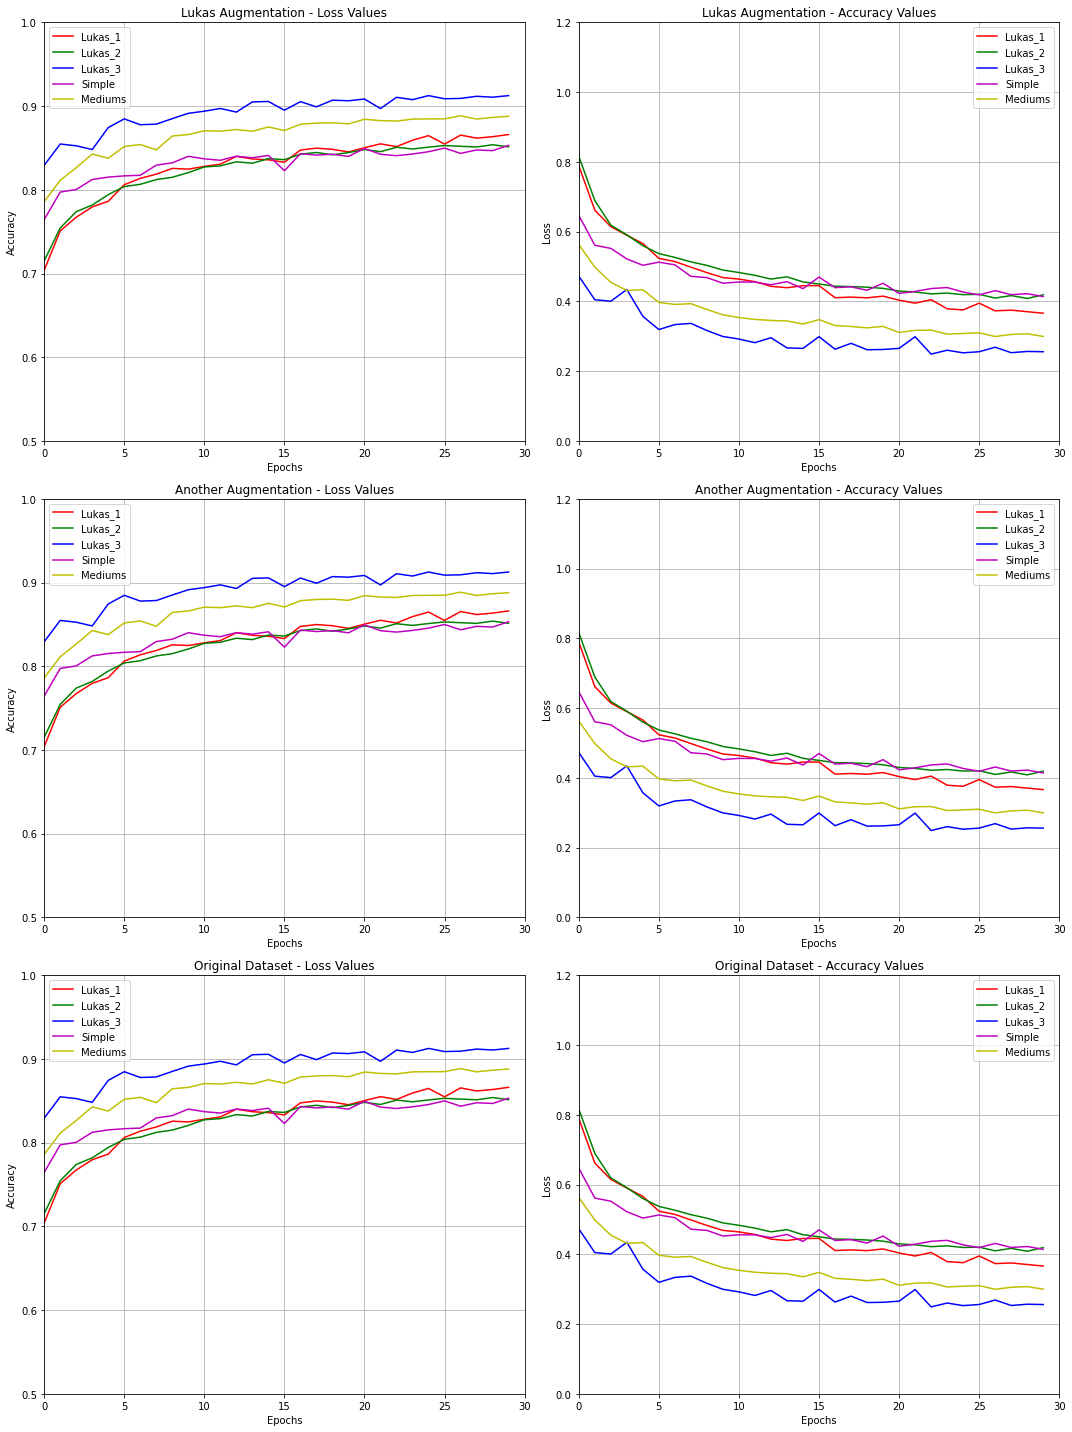

In [21]:
fig = plt.figure(figsize=(15, 20))
show_models(1, fig, AUG_1, LUKAS_AUGMENTATION, COLORS)
show_models(3, fig, AUG_1, ANOTHER_AUGMENTATION, COLORS)
show_models(5, fig, AUG_1, ORIGINAL_DATASET, COLORS)

plt.tight_layout()
plt.draw()

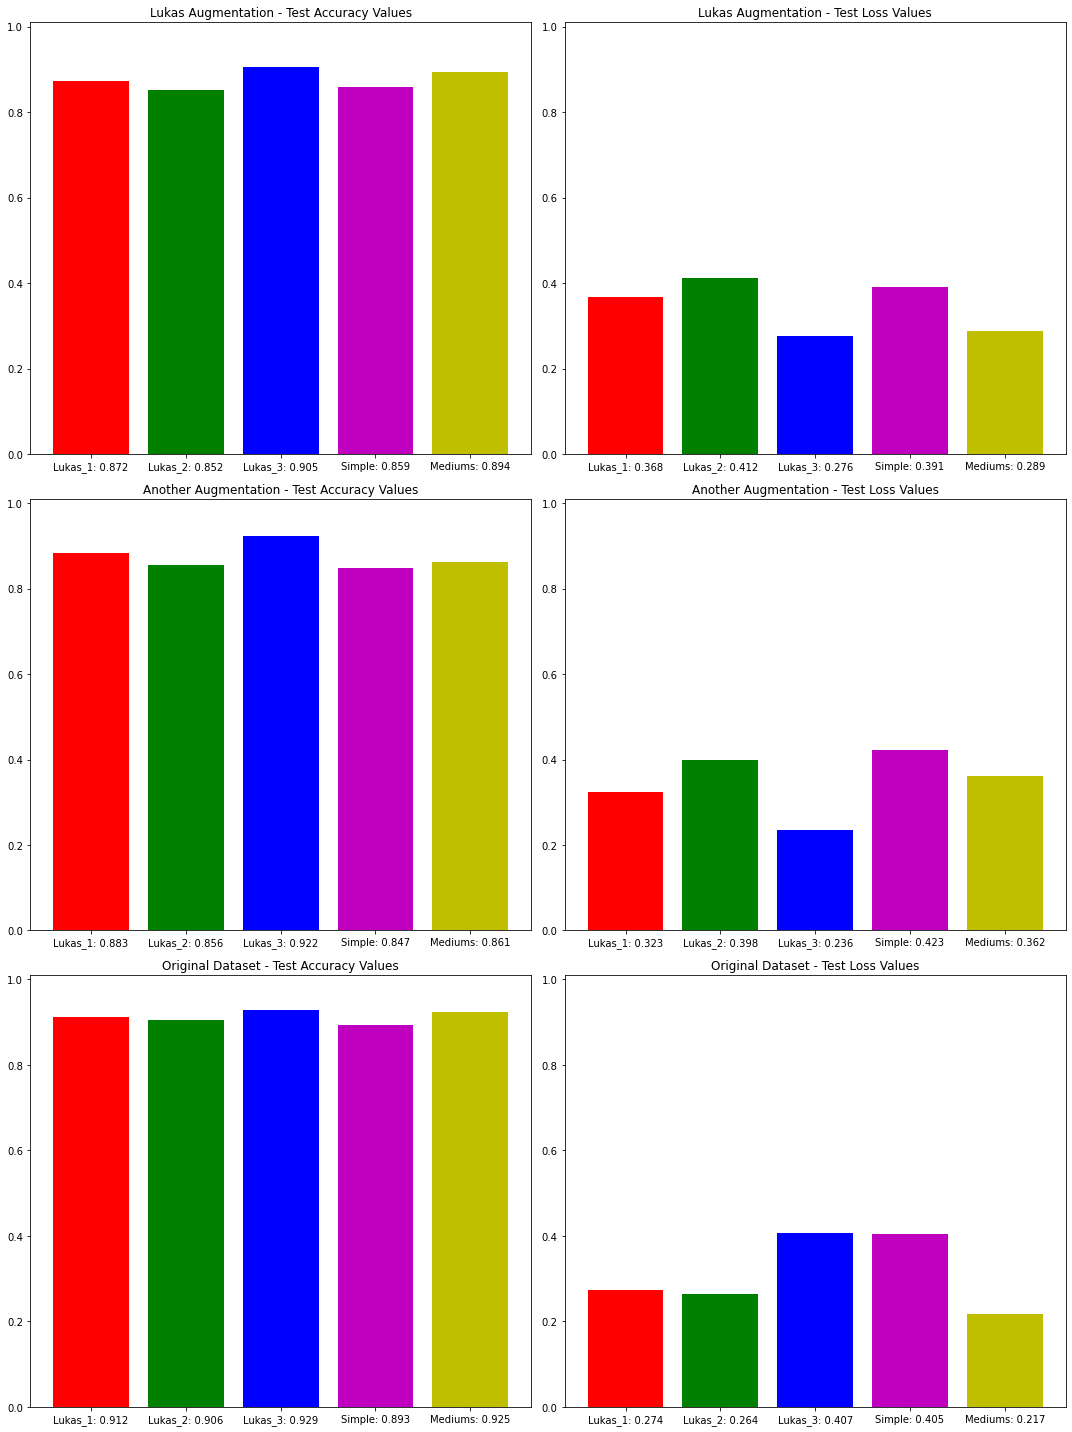

In [22]:
fig = plt.figure(figsize=(15, 20))
show_bar(2, LUKAS_AUGMENTATION, [loss_lukas_1_1, loss_lukas_2_1, loss_lukas_3_1, loss_simple_1, loss_mediums_1], COLORS)
show_bar(4, ANOTHER_AUGMENTATION, [loss_lukas_1_2, loss_lukas_2_2, loss_lukas_3_2, loss_simple_2, loss_mediums_2], COLORS)
show_bar(6, ORIGINAL_DATASET, [loss_lukas_1_3, loss_lukas_2_3, loss_lukas_3_3, loss_simple_3, loss_mediums_3], COLORS)
show_bar(1, LUKAS_AUGMENTATION, [acc_lukas_1_1, acc_lukas_2_1, acc_lukas_3_1, acc_simple_1, acc_mediums_1], COLORS)
show_bar(3, ANOTHER_AUGMENTATION, [acc_lukas_1_2, acc_lukas_2_2, acc_lukas_3_2, acc_simple_2, acc_mediums_2], COLORS)
show_bar(5, ORIGINAL_DATASET, [acc_lukas_1_3, acc_lukas_2_3, acc_lukas_3_3, acc_simple_3, acc_mediums_3], COLORS)

plt.tight_layout()
plt.draw()